# Introduction To Data Science - Final Project

## Group members:

| Name              | ID       |
|-------------------|----------|
| Pham Dang Son Ha |21127206|
| Tran Dai Nien     | 21127664 |
| Nguyen Cao Khoi   | 21127632 |
| Nguyen Phan Minh Triet  | 21126007  |

## Table of Contents

1. [Data Collection](#data-collection)

2. [Data Preprocessing and Exploration](#data-preprocessing-and-exploration)

3. [Data Modeling](#data-modeling)

4. [Reference](#references)

## Data Collection

### 1. Set-up environment

#### Import Required Libraries: Import the necessary Python libraries - requests, BeautifulSoup, pandas, and time.

In [722]:
#Necessary Packages
!pip install bs4
!pip install requests
!pip install pandas
!pip install numpy
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import os
import seaborn as sns

# modeling stuff
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import random

### 2. Collect data from a website by parsing HTML

#### List of collected information

Information related to the movie, including:

- `names`: Movie titles.
- `years`: Release years of the movies.
- `genres`: Categories or genres the movies belong to.
- `lengths`: Duration or length of the movies.
- `rating_stars`: Ratings received by the movies.
- `metascores`: Metascores assigned to the movies (if available).
- `votes`: Total votes accumulated by the movies.
- `grosses`: Box office gross earnings of the movies (if available).
- `directors`: Directors of the movies.
- `stars`: Lead actors/actresses in the movies.
- `descriptions`: Synopsis or descriptions of the movies.

#### Data Collection Process:

- Identify the URL of the webpage containing the list of movies to be scraped.
- Use the requests library to send GET requests to each page of the IMDb website.
- Parse the HTML of the webpage using BeautifulSoup to extract information about the movies.
- Iterate through each movie to collect details such as title, release year, genre, rating, - Metascore, votes, earnings, director, main cast, and description.
- Store the collected information in a DataFrame using the pandas library.

In [723]:
def collect_data(base_url, num_movies, movies_per_page=100):
    # Initialize lists for storing data
    names = []
    years = []
    genres = []
    lengths = []
    rating_stars = []
    metascores = []
    votes = []
    grosses = []
    directors = []
    stars = []
    descriptions = []

    # Iterate over the specified number of pages
    for page in range(1, int(num_movies / movies_per_page) + 1):
        try:
            # Construct the URL for the current page
            url = f"{base_url}&page={page}"
            
            # Send a GET request to the URL
            response = requests.get(url)
            time.sleep(2)  # Respectful crawling by adding delay

            # Check if the response status code is 200 (OK)
            if response.status_code == 200:
                # Parse the HTML content of the page
                soup = BeautifulSoup(response.text, 'html.parser')

                # Find all movie containers on the page
                movies = soup.find_all('div', class_='lister-item-content')

                # Process each movie
                for movie in movies:
                    # Extract movie details
                    name = movie.find('h3').find('a').text.strip()
                    year = movie.find('span', class_='lister-item-year').text.strip('()')
                    genre = movie.find('span', class_='genre').text.strip()
                    length = movie.find('span', class_='runtime').text.strip().split()[0]
                    rating = movie.find('span', class_='ipl-rating-star__rating').text.strip()

                    # Some movies might not have a metascore
                    metascore_tag = movie.find('span', class_='metascore')
                    metascore = metascore_tag.text.strip() if metascore_tag else 'N/A'

                    # Extract votes and gross, if available
                    nv_tags = movie.find_all('span', attrs={'name': 'nv'})
                    vote = nv_tags[0].text if nv_tags else 'N/A'
                    gross = nv_tags[1].text if len(nv_tags) > 1 else 'N/A'

                    # Extract director and stars
                    director, *star_list = movie.find_all('a', href=lambda href: href and 'name/nm' in href)
                    director = director.text
                    stars_str = ', '.join(star.text for star in star_list)

                    # Extract description
                    description = movie.find_all('p', class_='')[-1].text.strip()

                    # Append the extracted data to respective lists
                    names.append(name)
                    years.append(year)
                    genres.append(genre)
                    lengths.append(length)
                    rating_stars.append(rating)
                    metascores.append(metascore)
                    votes.append(vote)
                    grosses.append(gross)
                    directors.append(director)
                    stars.append(stars_str)
                    descriptions.append(description)

            else:
                print(f"Failed to process page {page}: Status code {response.status_code}")

        except requests.exceptions.RequestException as e:
            print(f"Request error on page {page}: {e}")
        except Exception as e:
            print(f"Error on page {page}: {e}")

    # Create a DataFrame with the collected data
    data = pd.DataFrame({
        'Name': names,
        'Year': years,
        'Genre': genres,
        'Length': lengths,
        'Rating': rating_stars,
        'Metascore': metascores,
        'Votes': votes,
        'Gross': grosses,
        'Director': directors,
        'Stars': stars,
        'Description': descriptions
    })

    return data

#### Collecting Movie Data from IMDb

- Identify the URL of the webpage containing the list of movies to be scraped.

- Use the collect_data function to gather information from the webpage based on the desired number of pages and movies.


In [724]:
# Specify the URL containing the list of movies
url = "https://www.imdb.com/list/ls051785783/?st_dt=&mode=detail&sort=list_order,asc"

# Scrape the data

if os.path.isfile('data_film.csv'):
  data_film = pd.read_csv('data_film.csv')
else: 
  data_film = collect_data(url, 1500, 100)

#### Data Storage

- Store the collected data in a CSV file named data_film.csv using data_film.to_csv().
- Read the data from the CSV file into a new DataFrame (data_film) using pd.read_csv().

In [725]:
#Save to csv file with name data_film.csv
# Save the DataFrame to a CSV file without including the index
data_film.to_csv("data_film.csv", index=False)

# Read the CSV file into a new DataFrame called data_film
data_film = pd.read_csv("data_film.csv")

# Display the 'data_film' DataFrame
data_film

,Name,Year,Genre,Length,Rating,Metascore,Votes,Gross,Director,Stars,Description
0,Bố Già,1972,"Crime, Drama",175,9.2,100.0,"1,967,180",$134.97M,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...","Don Vito Corleone, head of a mafia family, dec..."
1,Chuyện Tình Thế Chiến,1942,"Drama, Romance, War",102,8.5,100.0,"595,530",$1.02M,Michael Curtiz,"Humphrey Bogart, Ingrid Bergman, Paul Henreid,...",A cynical expatriate American cafe owner strug...
2,Sinh Viên Tốt Nghiệp,1967,"Comedy, Drama, Romance",106,8.0,83.0,"284,817",$104.95M,Mike Nichols,"Dustin Hoffman, Anne Bancroft, Katharine Ross,...",A disillusioned college graduate finds himself...
3,Công Dân Kane,1941,"Drama, Mystery",119,8.3,100.0,"458,887",$1.59M,Orson Welles,"Orson Welles, Joseph Cotten, Dorothy Comingore...",Following the death of publishing tycoon Charl...
4,12 Người Đàn Ông Giận Dữ,1957,"Crime, Drama",96,9.0,97.0,"841,356",$4.36M,Sidney Lumet,"Henry Fonda, Lee J. Cobb, Martin Balsam, John ...",The jury in a New York City murder trial is fr...
...,...,...,...,...,...,...,...,...,...,...,...
1495,Quái Thú Vô Hình,1987,"Action, Adventure, Horror",107,7.8,47.0,"444,578",$59.74M,John McTiernan,"Arnold Schwarzenegger, Carl Weathers, Kevin Pe...",A team of commandos on a mission in a Central ...
1496,Chuyến Du Lịch Châu Âu,2004,Comedy,92,6.6,45.0,"218,869",$17.72M,Jeff Schaffer,"Alec Berg, David Mandel, Scott Mechlowicz, Jac...","Dumped by his girlfriend, a high school grad d..."
1497,Champagne,1928,Comedy,86,5.4,NaN,"2,572",NaN,Alfred Hitchcock,"Betty Balfour, Jean Bradin, Ferdinand von Alte...",A spoiled heiress defies her father by running...
1498,Thế Giới Không Đủ,1999,"Action, Adventure, Thriller",128,6.4,57.0,"207,600",$126.94M,Michael Apted,"Pierce Brosnan, Sophie Marceau, Robert Carlyle...",James Bond uncovers a nuclear plot while prote...


## Data Exploration And Preprocessing

### 1) How many rows and columns

- There are 1500 rows and 11 columns

In [726]:
data_film.shape

(1500, 11)

### 2) What is the meaning of each row?

- Each row represents the information of a film(name, year, genres,...)

In [727]:
data_film.sample(1)

,Name,Year,Genre,Length,Rating,Metascore,Votes,Gross,Director,Stars,Description
1471,Con Ma Vui Vẻ,1995,"Comedy, Family, Fantasy",100,6.2,49.0,"144,877",$100.33M,Brad Silberling,"Bill Pullman, Christina Ricci, Cathy Moriarty,...",An afterlife therapist and his daughter meet a...


### 3) Are there duplicated rows?

There is 0 duplicated row

In [728]:
data_film.duplicated().sum()

0

### 4) What is the meaning of each columns

- `names`: Movie titles.
- `years`: Release years of the movies.
- `genres`: Categories or genres the movies belong to.
- `lengths`: Duration or length of the movies.
- `rating_stars`: Ratings received by the movies.
- `metascores`: Metascores assigned to the movies (if available).
- `votes`: Total votes accumulated by the movies.
- `grosses`: Box office gross earnings of the movies (if available).
- `directors`: Directors of the movies.
- `stars`: Lead actors/actresses in the movies.
- `descriptions`: Synopsis or descriptions of the movies.

### 5) What is the current data type of each column? Are there any columns having inappropriate data types?

In [729]:
data_film.dtypes

Name            object
Year            object
Genre           object
Length           int64
Rating         float64
Metascore      float64
Votes           object
Gross           object
Director        object
Stars           object
Description     object
dtype: object

In [730]:
data_film.sample(1)

,Name,Year,Genre,Length,Rating,Metascore,Votes,Gross,Director,Stars,Description
833,30' Sau Nửa Đêm,2012,"Drama, History, Thriller",157,7.4,95.0,"314,231",$95.72M,Osama bin Laden,"Kathryn Bigelow, Jessica Chastain, Joel Edgert...",A chronicle of the decade-long hunt for al-Qae...


- There are some columns which have inappropriate type: `Year, Votes, Gross`

- For `Year, Votes` we can simply convert them into **numeric**. But with `Gross` we need to change columns name to `Gross(M$)` to indicated that `Gross` unit is million Dollars

In [731]:
# remove ',' in Votes
data_film.Votes = data_film.Votes.str.replace(',', '')

# remove $, M in Gross and create new column `Gross(M$)`
data_film['Gross(M$)'] = data_film.Gross.str.replace('M', '').str.replace('$', '')

# drop Gross
data_film.drop(columns='Gross', inplace=True)

In [732]:
data_film.sample(1)

,Name,Year,Genre,Length,Rating,Metascore,Votes,Director,Stars,Description,Gross(M$)
1416,Killing Them Softly,2012,"Crime, Drama, Thriller",97,6.2,64.0,150517,Andrew Dominik,"Brad Pitt, Ray Liotta, Richard Jenkins, Scoot ...",Jackie Cogan is an enforcer hired to restore o...,15.03


- Convert them into **numeric**

In [733]:
to_numeric_cols = ['Year', 'Votes', 'Gross(M$)']

for col in to_numeric_cols:
  data_film[col] = pd.to_numeric(data_film[col], errors='coerce')

data_film.dtypes

Name            object
Year           float64
Genre           object
Length           int64
Rating         float64
Metascore      float64
Votes            int64
Director        object
Stars           object
Description     object
Gross(M$)      float64
dtype: object

### 6) With each numerical column, how are values distributed?

- All numerical columns:

In [734]:
numerical_cols = data_film.columns[(data_film.dtypes != 'object')]
numerical_cols

Index(['Year', 'Length', 'Rating', 'Metascore', 'Votes', 'Gross(M$)'], dtype='object')

#### 6.1) What is the percentage of missing values?

- Number of missing values of each columns

In [735]:
data_film[numerical_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       1472 non-null   float64
 1   Length     1500 non-null   int64  
 2   Rating     1500 non-null   float64
 3   Metascore  1211 non-null   float64
 4   Votes      1500 non-null   int64  
 5   Gross(M$)  1121 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 70.4 KB


- The percentage of missing values for each columns

In [736]:
data_film.isnull().mean() * 100

Name            0.000000
Year            1.866667
Genre           0.000000
Length          0.000000
Rating          0.000000
Metascore      19.266667
Votes           0.000000
Director        0.000000
Stars           0.000000
Description     0.000000
Gross(M$)      25.266667
dtype: float64

> `Gross(M$)` and `Metascore` missing value's percentage are high

- The distribution of numerical attributes

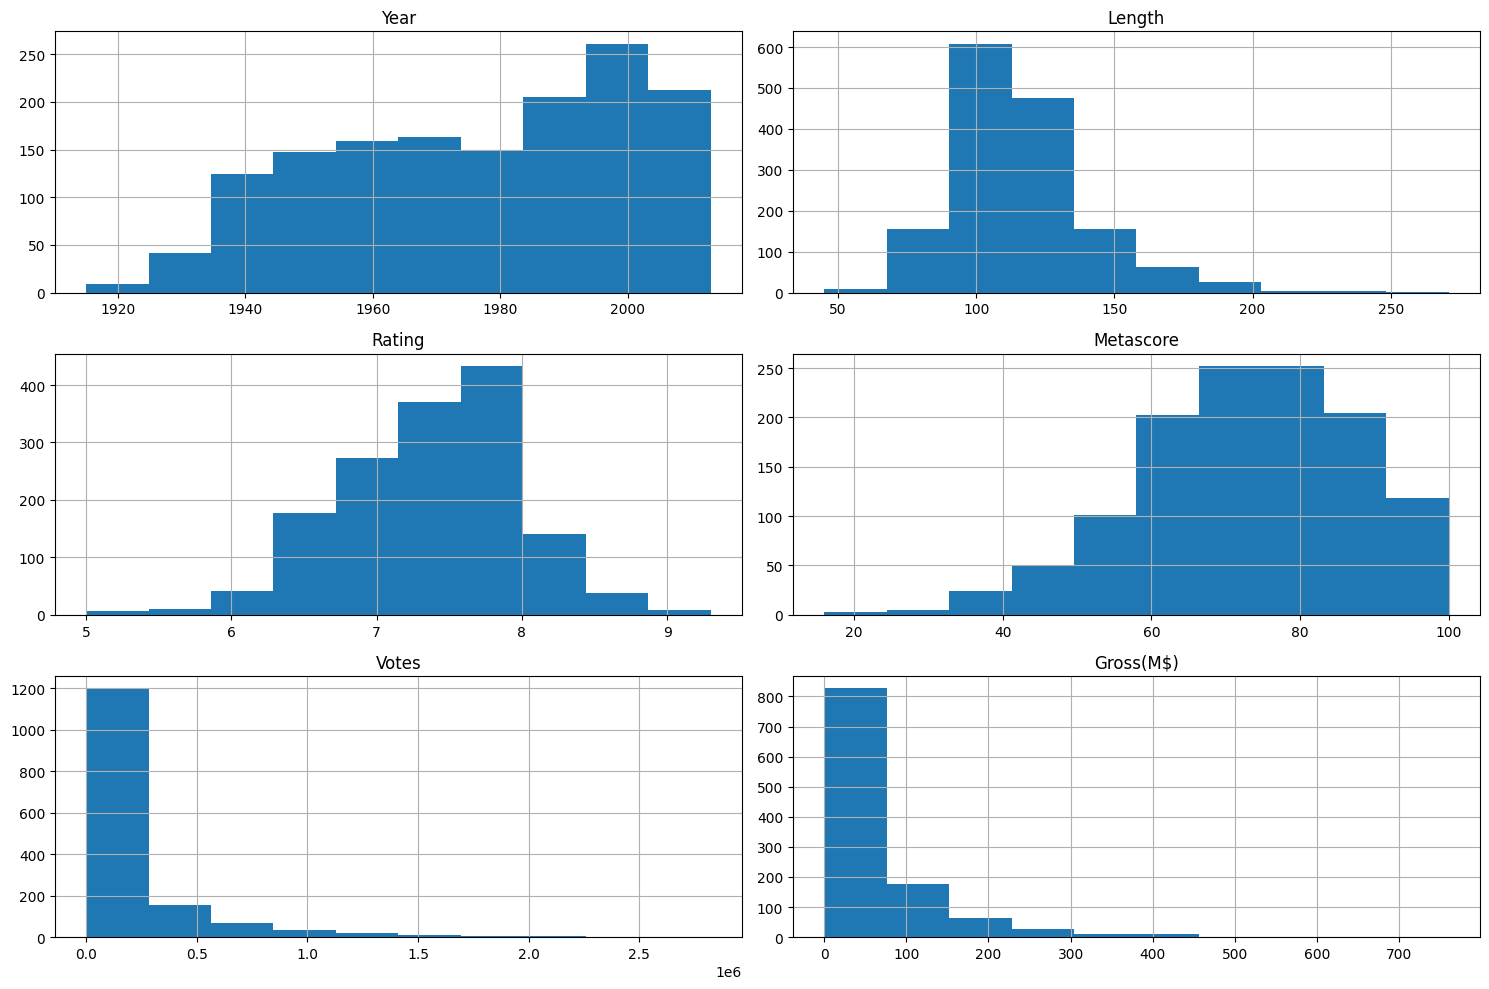

In [737]:
data_film[numerical_cols].hist(figsize=(15, 10))
plt.tight_layout()
plt.show();

- General statistics of numerical attributes

In [738]:
data_film[numerical_cols].describe()

,Year,Length,Rating,Metascore,Votes,Gross(M$)
count,1472.000000,1500.000000,1500.000000,1211.000000,1.500000e+03,1121.000000
mean,1976.701087,115.578667,7.372667,72.841453,1.982493e+05,61.061802
std,23.640039,25.450913,0.613360,14.646850,3.254139e+05,80.618053
min,1915.000000,45.000000,5.000000,16.000000,4.400000e+02,0.010000
25%,1957.000000,99.000000,7.000000,63.000000,1.929475e+04,10.250000
50%,1980.000000,112.000000,7.400000,73.000000,7.339200e+04,32.870000
75%,1998.000000,127.000000,7.800000,84.000000,2.280785e+05,78.900000
max,2013.000000,271.000000,9.300000,100.000000,2.822322e+06,760.510000


### 7) With each categorical column, how are values distributed?

- Quick glance at categorical columns

In [739]:
categorical_cols = data_film.columns[data_film.dtypes == 'object']

categorical_cols

Index(['Name', 'Genre', 'Director', 'Stars', 'Description'], dtype='object')

- Missing values = 0

In [740]:
for col in categorical_cols:
  print((data_film[col] == 'nan').sum(), data_film[col].isna().sum())

0 0
0 0
0 0
0 0
0 0


- The distribution of `Name`: the counts is not significantly different so we won't plot this

In [741]:
data_film.Name.value_counts()

Name
King Kong               2
Cặp Bài Trùng           2
Kẻ Cắp Gặp Bà Già       2
Cuộc Sống Tươi Đẹp      2
Ngôi Nhà Ma             2
                       ..
Đội Nhặt Banh           1
Peter Pan               1
Cối Xay Gió Đỏ          1
Người Áp Chế            1
You Gotta Stay Happy    1
Name: count, Length: 1489, dtype: int64

- The distribution of `Genre`

In [742]:
data_film.Genre.value_counts()

Genre
Drama                        96
Comedy, Drama, Romance       73
Drama, Romance               70
Comedy                       69
Comedy, Drama                62
                             ..
Comedy, Fantasy, Musical      1
Drama, Horror, Mystery        1
Mystery, Sci-Fi, Thriller     1
Action, Crime, Romance        1
Action, Adventure, Horror     1
Name: count, Length: 235, dtype: int64

- The distribution of top 20 `Genres`

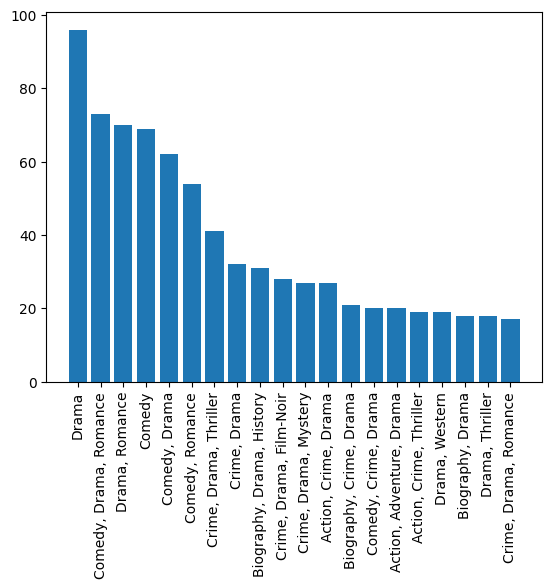

In [743]:
genre_counts = data_film.Genre.value_counts()[:20]
plt.bar(genre_counts.index, genre_counts.values);
plt.xticks(rotation=90)
plt.show();

- The distribution of `Director`

In [744]:
data_film.Director.value_counts()

Director
Alfred Hitchcock    34
Woody Allen         24
Steven Spielberg    17
Clint Eastwood      15
Martin Scorsese     14
                    ..
Henry King           1
Richard Kelly        1
Bob Rafelson         1
Mike Mills           1
Michael Apted        1
Name: count, Length: 658, dtype: int64

- The distribution of top 20 `Director`

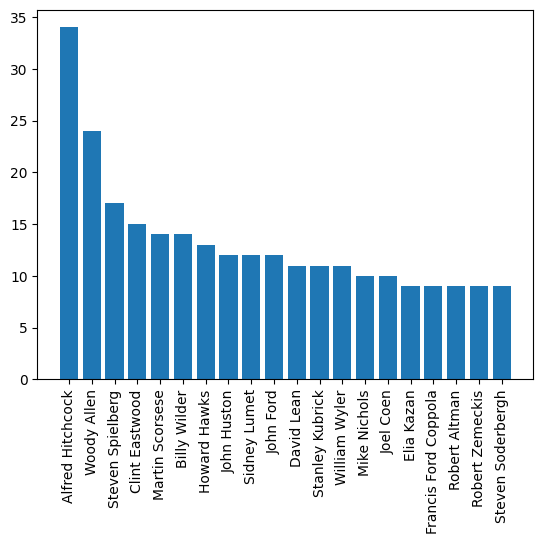

In [745]:
director_counts = data_film.Director.value_counts()[:20]
plt.bar(director_counts.index, director_counts.values);
plt.xticks(rotation=90)
plt.show()

- The distribution of `Stars`: The counts is not significantly different so we won't plot this attribute

In [746]:
data_film.Stars.value_counts()

Stars
Sylvester Stallone, Talia Shire, Burt Young, Carl Weathers                                                     4
Lewis Stone, Mickey Rooney, Cecilia Parker, Fay Holden                                                         2
Bill Murray, Dan Aykroyd, Sigourney Weaver, Harold Ramis                                                       2
Mark Hamill, Harrison Ford, Carrie Fisher, Billy Dee Williams                                                  2
Mickey Rooney, Lewis Stone, Fay Holden, Cecilia Parker                                                         2
                                                                                                              ..
Wilfred Jackson, Hamilton Luske, Jack Kinney, Bobby Driscoll, Kathryn Beaumont, Hans Conried, Bill Thompson    1
Nicole Kidman, Ewan McGregor, John Leguizamo, Jim Broadbent                                                    1
Joaquin Phoenix, Philip Seymour Hoffman, Amy Adams, Jesse Plemons                         

- The distribution of `Description`: each description is different so we won't plot this

In [747]:
data_film.Description.value_counts()

Description
Don Vito Corleone, head of a mafia family, decides to hand over his empire to his youngest son Michael. However, his decision unintentionally puts the lives of his loved ones in grave danger.                   1
One year after Kevin McCallister was left home alone and had to defeat a pair of bumbling burglars, he accidentally finds himself stranded in New York City - and the same criminals are not far behind.          1
A husband-and-wife team play detective, but not in the traditional sense. Instead, the happy duo helps others solve their existential issues, the kind that keep you up at night, wondering what it all means.    1
After his auto-parts tycoon father dies, the overweight, underachieving son teams up with a snide accountant to try and save the family business.                                                                 1
A boy and a girl from different backgrounds fall in love regardless of their upbringing - and then tragedy strikes.                         

#### 7.1) What is the percentage of missing values?

- As we can see all the categorical columns has 0 missing value so the perccentage will be: 0%

### 8) Are they abnormal?

- After considering the distribution of each attributes, we can conclude that the values are good enough for us to use for model training and get insights from them. But first, we need to preprocessing the data.

### 9) Making questions for exploration?

#### 9.1) Question 1: Which genres should we as a director want to make with?

- Purposes: By analyzing historical data on movie ratings and box office performance across different genres, we can identify which genres tend to be more well-received by audiences and/or more profitable. This can help the director choose a genre that aligns with their goals, whether it’s to create a critically acclaimed film, a box office hit, or both.

- Approaches: 

    + `Analyzing on Rating`: We can group the data by genres and calculate the average Rating (or Metascore) for each genre. This can give us an idea of which genres are generally more well-received.

    + `Analyzing on Gross`: We can group the data by genres and calculate the average Gross for each genre. This can give us an idea of which genres are generally more profitable.

##### Exploring about the genre of the movies

In [748]:
# We'll split the genres column into separate rows
df_genres = data_film.assign(Genre_Split=data_film['Genre'].str.split(',')).explode('Genre_Split')

# Remove leading and trailing spaces
df_genres['Genre_Split'] = df_genres['Genre_Split'].str.strip()

# Get unique genres
unique_genres = df_genres['Genre_Split'].unique()

# Print the number of unique genres
print("Number of unique genres:", len(unique_genres))

# Print all unique genres
print("Unique genres:", unique_genres)


Number of unique genres: 21
Unique genres: ['Crime' 'Drama' 'Romance' 'War' 'Comedy' 'Mystery' 'Action' 'Western'
 'Thriller' 'Adventure' 'Family' 'Fantasy' 'Film-Noir' 'Biography'
 'History' 'Sci-Fi' 'Sport' 'Horror' 'Music' 'Musical' 'Animation']


- Explanation:

    + `Crime`: These films revolve around the sinister actions of criminals, mobsters, bank robbers, underworld figures, and ruthless hoodlums who operate outside the law, stealing and murdering their way through life.
    
    + `Drama`: Drama films are serious presentations or stories with settings or life situations that portray realistic characters in conflict with either themselves, others, or forces of nature.

    + `Romance`: Romance films are love stories that focus on passion, emotion, and the affectionate romantic involvement of the main characters, and the journey that their love takes them through dating, courtship or marriage.
    
    + `War`: War films acknowledge the horror and heartbreak of war, letting the actual combat fighting or conflict (against nations or humankind) provide the primary plot or background for the action of the film.

    + `Comedy`: Comedies are light-hearted plots consistently and deliberately designed to amuse and provoke laughter (with one-liners, jokes, etc.) by exaggerating the situation, the language, action, relationships and characters.

    + `Mystery`: These are types of films that make us think and keep us guessing. They deal with our sense of unease and anxiety.

    + `Action`: Action films usually include high energy, big-budget physical stunts and chases, possibly with rescues, battles, fights, escapes, destructive crises (floods, explosions, natural disasters, fires, etc.), non-stop motion, spectacular rhythm and pacing, and adventurous, often two-dimensional ‘good-guy’ heroes (or recently, heroines) battling ‘bad guys’ - all designed for pure audience escapism.
    
    + `Western`: Westerns are the major defining genre of the American film industry, a nostalgic eulogy to the early days of the expansive, untamed American frontier (the borderline between civilization and the wilderness).
    
    + `Thriller`: Thrillers are tension-laden, complex, mysterious, and often involve crime (solution of a murder, disappearance, theft, etc.).
    
    + `Adventure`: Adventure films are exciting stories, with new experiences or exotic locales, very 
    similar to or often paired with the action film genre.

    + `Family`: These are films that are designed to be suitable for all ages.

    + `Fantasy`: Fantasy films are films with fantastic themes, usually involving magic, supernatural 
    events, mythology, folklore, or exotic fantasy worlds.
    
    + `Film-Noir`: Film noir is a cinematic term used primarily to describe stylish Hollywood crime dramas, particularly those that emphasize cynical attitudes and sexual motivations.
    
    + `Biography`: These films depict and dramatize the life of an important historical personage (or group) from the past or present era.
    
    + `History`: Films in this genre focus on recreating a specific and important period or event in history.
    
    + `Sci-Fi`: Science fiction films are often quasi-scientific, visionary and imaginative - complete with heroes, aliens, distant planets, impossible quests, improbable settings, fantastic places, great dark and shadowy villains, futuristic technology, unknown and unknowable forces, and extraordinary monsters (‘things or creatures from space’), either created by mad scientists or by nuclear havoc.
    
    + `Sport`: Sports films are those that have a sports setting (football or baseball stadium, arena, or the Olympics, etc.), competitive event (the ‘big game,’ ‘fight,’ or ‘race’), athletes (boxers, racers, etc.), or coach in the storyline.
    
    + `Horror`: Horror films are designed to frighten and to invoke our hidden worst fears, often in a terrifying, shocking finale, while captivating and entertaining us at the same time in a cathartic experience.
    
    + `Music`: These are films that are centered around music and dance.
    
    + `Musical`: Musicals/Dance films are cinematic forms that emphasize and showcase full-scale song and dance routines in a significant way (usually with a musical or dance performance integrated as part of the film narrative, or as an unrealistic “eruption” within the film).

    + `Animation`: Animated films are ones in which individual drawings, paintings, or illustrations are photographed frame by frame.

##### Analyzing on Rating

c:\Users\NC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\NC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\NC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


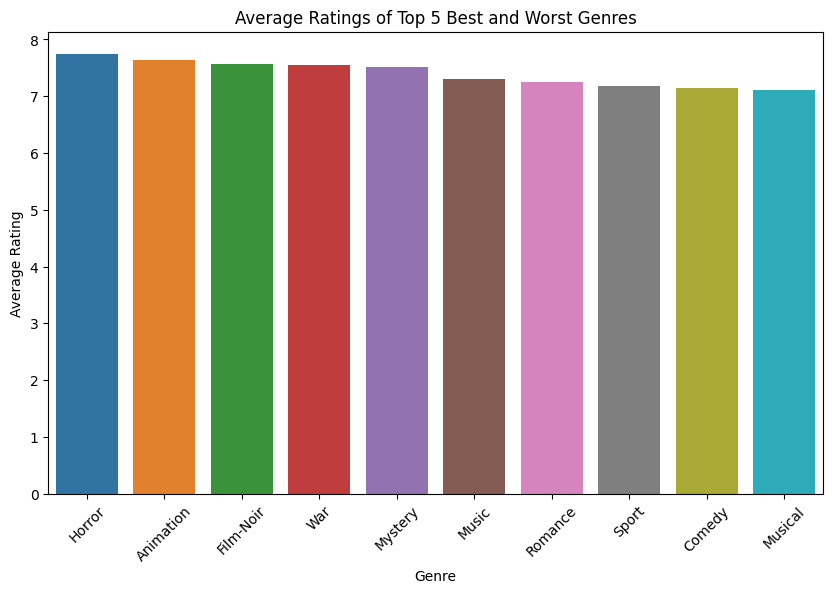

In [749]:
# Then, we group by genres and calculate the average rating_stars
average_ratings = df_genres.groupby('Genre_Split')['Rating'].mean()

# Finally, we sort the result in descending order so the genres with the highest average ratings are on top
average_ratings = average_ratings.sort_values(ascending=False)

# Get the top 5 and bottom 5 genres
top_5 = average_ratings.head(5)
bottom_5 = average_ratings.tail(5)

# Combine them into one Series
combined = pd.concat([top_5, bottom_5])

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=combined.index, y=combined.values)
plt.title('Average Ratings of Top 5 Best and Worst Genres')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()

=> Conclusion: Based on the data analysis, the top five genres with the highest average rating scores are Horror, Animation, Film-Noir, War, and Mystery. This suggests that movies in these genres tend to be more well-received by audiences, as indicated by their higher average ratings.

On the other hand, the genres with the lowest average rating scores are Musical, Comedy, Sport, Romance, Music. This suggests that movies in these genres tend to receive lower ratings from audiences.

This analysis provides a general trend and can be a useful guide for filmmakers when choosing a genre for their next project.

##### Analyzing on Gross

c:\Users\NC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\NC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\NC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


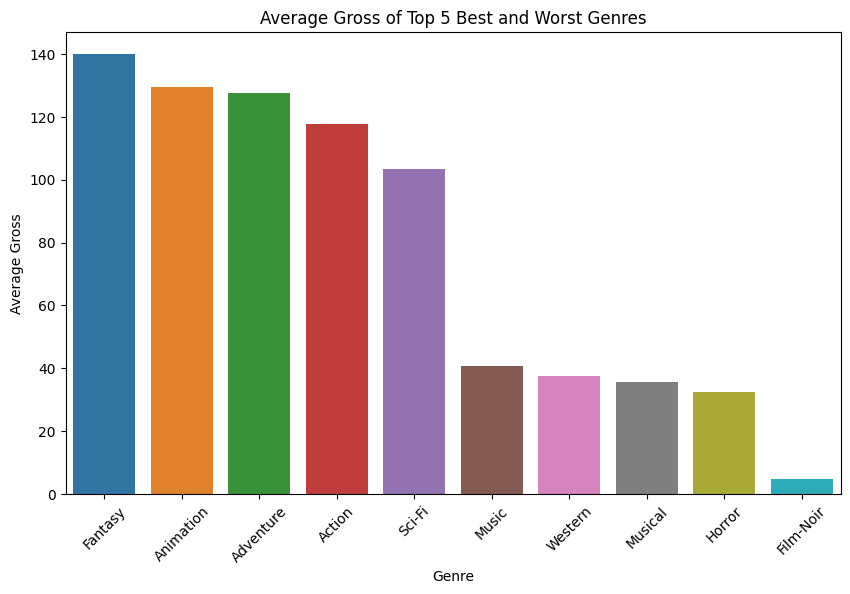

In [750]:
# Group by genres and calculate the average gross
average_gross = df_genres.groupby('Genre_Split')['Gross(M$)'].mean()

# Sort the result in descending order so the genres with the highest average gross are on top
average_gross = average_gross.sort_values(ascending=False)

# Get the top 5 and bottom 5 genres
top_5_gross = average_gross.head(5)
bottom_5_gross = average_gross.tail(5)

# Combine them into one Series
combined_gross = pd.concat([top_5_gross, bottom_5_gross])

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=combined_gross.index, y=combined_gross.values)
plt.title('Average Gross of Top 5 Best and Worst Genres')
plt.xlabel('Genre')
plt.ylabel('Average Gross')
plt.xticks(rotation=45)
plt.show()

=> Conclusion: Based on the data analysis, the top five genres with the highest average gross are Fantasy, Animation, Adventure, Action and Sci-Fi. This suggests that movies in these genres tend to be more priftable, as indicated by their higher gross.

On the other hand, the genres with the lowest gross are Film-Noir, Horror, Musical, Western and Music. This suggests that movies in these genres tend to receive lower gross and not popluar with audiences.

This analysis provides a general trend and can be a useful guide for filmmakers when choosing a genre for their next project.

##### Final conclusion: 

    + Animation is the genre which tend to be more favoured by audiences and bring more profit for the filmakers because of it's high value on both Rating and Gross
    
    + Music and Musical are the 2 types of genre that generally bring low income to the company and are not favourable among audiences

#### 9.2) Question 2: How have the movie lengths and genres evolved over the year?

- Purpose: 

    + To understand the trends and changes in movie lengths and genres over time. This can provide insights into how the film industry has evolved and changed, reflecting shifts in cultural tastes, technological advancements, and other factors.

    + By analyzing this, we can gain a deeper understanding of the film industry’s history and potentially predict future trends. For filmmakers, this information could be useful in making decisions about what type of films to produce. For film enthusiasts or researchers, it could provide interesting insights into the evolution of cinema. 

- Appoaches:

    + `Yearly Average Movie Length`: Group the data by year and calculate the average movie length for each year. Plotting these averages over time can show how movie lengths have changed.

    + `Genre Popularity Over Time`: For each year, calculate the number of movies produced in each genre. Plotting these numbers can show how the popularity of different genres has evolved.

##### Yearly Average Movie Length

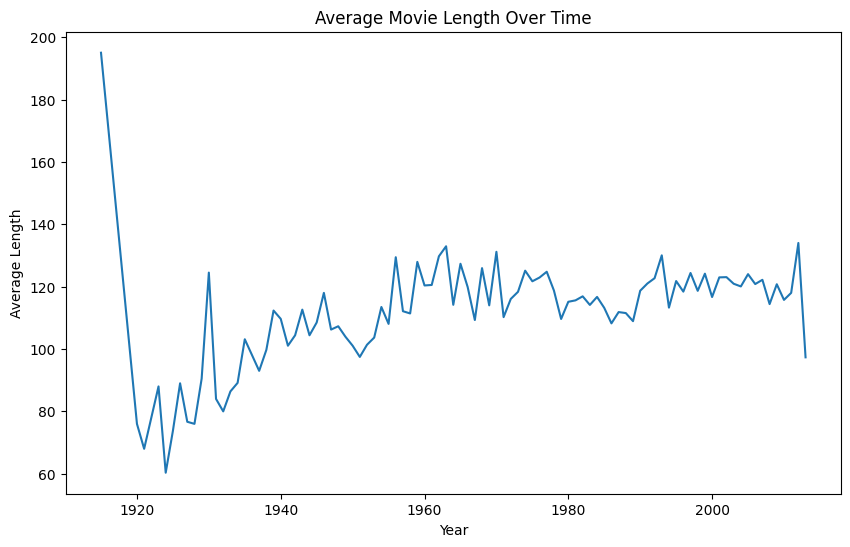

In [751]:
# Group by year and calculate the average length
average_lengths = data_film.groupby('Year')['Length'].mean()

# Plot the data
plt.figure(figsize=(10, 6))
average_lengths.plot(kind='line')
plt.title('Average Movie Length Over Time')
plt.xlabel('Year')
plt.ylabel('Average Length')
plt.show()

=> Conclusion: Over the given period, the length of movies as a whole decrease from roughly 200 minutes to around 90 minutes per movie.
Around 1920, the length of the movies witnessed a sharp decrease from around 200 to 75 minutes. After that time the length of the movies fuctuate between 60 and 120 minutes. In the recent years the length of the movies is falling and likely still fall in the future


##### Genre Popularity Over Time

C:\Users\NC\AppData\Local\Temp\ipykernel_16260\2575019706.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genre_counts = copy_df_genres.groupby(['Time_Period', 'Genre_Split']).size()


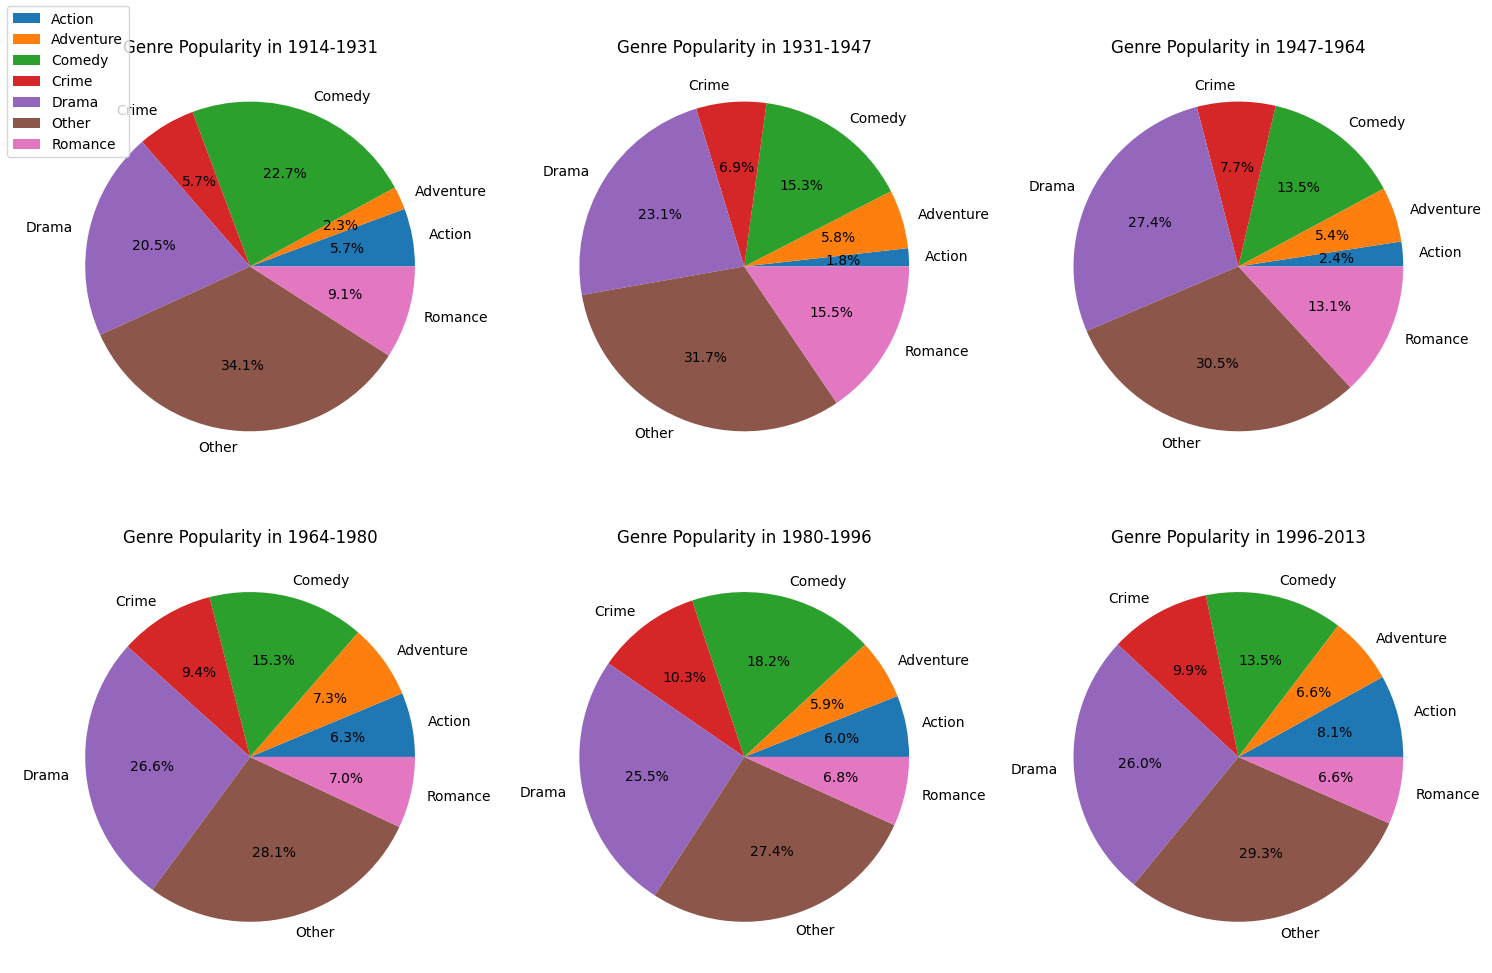

In [752]:
#Make a copy of df_genres
copy_df_genres = df_genres.copy()

# Get the top 5 genres
top_genres = copy_df_genres['Genre_Split'].value_counts().index[:6]

# Replace all other genres with 'Other'
copy_df_genres['Genre_Split'] = copy_df_genres['Genre_Split'].where(copy_df_genres['Genre_Split'].isin(top_genres), 'Other')

# Convert the 'Year' column to numeric, coercing errors to NaN
copy_df_genres['Year'] = pd.to_numeric(copy_df_genres['Year'], errors='coerce')

# Drop rows with NaN in the 'Year' column
copy_df_genres = copy_df_genres.dropna(subset=['Year'])

# Divide the data into six time periods
copy_df_genres['Time_Period'] = pd.cut(copy_df_genres['Year'], bins=6)

# Count the number of movies in each genre for each time period
genre_counts = copy_df_genres.groupby(['Time_Period', 'Genre_Split']).size()

# Reset the index to make 'Time_Period' and 'Genre_Split' regular columns
genre_counts = genre_counts.reset_index(name='Count')

# Get the unique time periods
time_periods = genre_counts['Time_Period'].unique()

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Loop over the time periods and plot the data in a separate subplot
for i, period in enumerate(time_periods):
    # Get the data for this time period
    data = genre_counts[genre_counts['Time_Period'] == period]
    
    # Calculate the row and column indices for the subplot
    row = i // 3
    col = i % 3
    
    # Create the pie chart in the subplot
    axs[row, col].pie(data['Count'], labels=data['Genre_Split'], autopct='%1.1f%%')
    axs[row, col].set_title('Genre Popularity in ' + str(int(period.left)) + '-' + str(int(period.right)))

# Add a legend
fig.legend(genre_counts['Genre_Split'].unique(), loc='upper left')

# Adjust the layout
plt.tight_layout()
plt.show()

=> Conclusion: In general, Drama , which over the six period accounts for 20%-25%, is the most popular genre among all.

Over the time, the proportion of Crime, Adventure and Action increase over the years. In contrast, the percentage of Comedy and Romance movies falls over the given period.

##### Final conclusion:

+ The length of a movie decrease over time and this status seem to continue in the future

+ Drama movie is the most popular movie type. Over the time the proportion of Crime, Adventure and Action increases, the percentage of Comedy and Romance decreases.

#### 9.3) Question 3: Does a good movie  comes with certain actors/actress?

- Purposes:

    + To understand if the presence of certain actors or actresses in a movie can be a predictor of the movie’s quality or success. It can help in understanding trends in the film industry and can potentially guide decisions about casting for future films.

    + Help viewers to find the good movies to watch just based on the casts.

- Approaches:

    + Step 1 - Define Success: We need to define what a “good” movie is. It could be based on Rating, Gross, or a combination of factors.

    + Step 2 - Identify Top Actors/Actresses: Identify the top actors/actresses based on the number of movies they’ve starred in, their average movie ratings, gross earnings, or a combination of these.

    + Step 3 - Analyze Movie Success: For each of the top actors/actresses, calculate the average Rating and Gross of the movies they’ve starred in. Compare these averages to the overall averages to see if movies featuring these actors/actresses tend to be more successful.

    + Step 4 - Visualize the Results: Create bar plots or other visualizations to compare the success of movies with different actors/actresses. This could help visually identify any trends or patterns.

##### Exploring about the Stars in the movie data

In [753]:
# We'll split the Stars column into separate rows
df_stars = data_film.assign(Stars_Split=data_film['Stars'].str.split(',')).explode('Stars_Split')

# Remove leading and trailing spaces
df_stars['Stars_Split'] = df_stars['Stars_Split'].str.strip()

# Get unique stars
unique_stars = df_stars['Stars_Split'].unique()

# Print the number of unique stars
print("Number of unique stars:", len(unique_stars))

# Print all unique stars
print("Unique stars:", unique_stars)

Number of unique stars: 3061
Unique stars: ['Marlon Brando' 'Al Pacino' 'James Caan' ... 'Robert Carlyle'
 'Denise Richards' 'Roland Young']


##### Exploring the success of each star

c:\Users\NC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\NC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\NC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


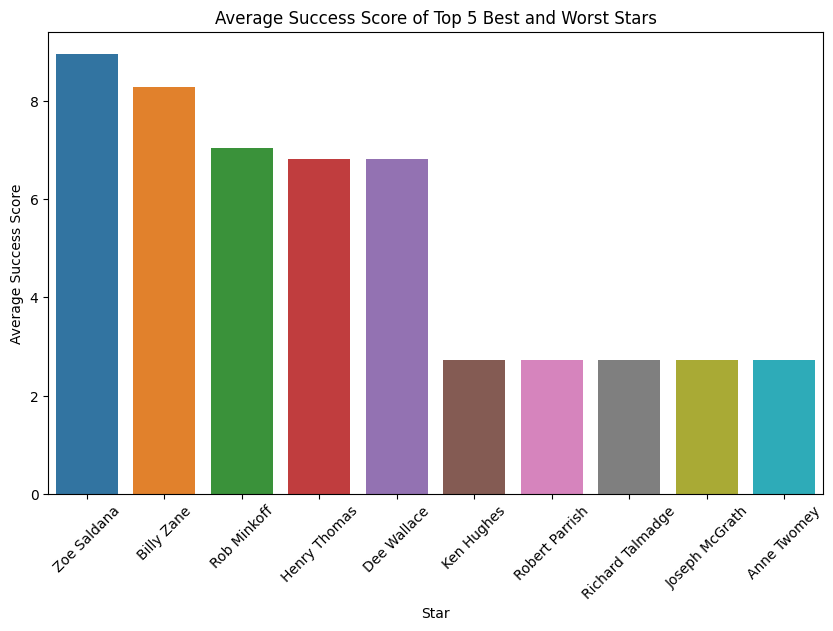

In [754]:
# Calculate the median of 'Gross(M$)'
gross_median = df_stars['Gross(M$)'].median()

# Fill in missing values in 'Gross(M$)' with the median
df_stars['Gross(M$)'].fillna(gross_median, inplace=True)

# Normalize 'grosses' to a 0-10 scale to create 'Gross_Point'
df_stars['Gross_Point'] = (df_stars['Gross(M$)'] - df_stars['Gross(M$)'].min()) / (df_stars['Gross(M$)'].max() - df_stars['Gross(M$)'].min()) * 10

# Create 'Success' column as the average of 'rating_stars' and 'Gross_Point'
df_stars['Success'] = df_stars[['Rating', 'Gross_Point']].mean(axis=1)

# Group the data by 'Stars_Split' and calculate the average 'Success' for each star
average_success= df_stars.groupby('Stars_Split')['Success'].mean()

# Sort the average success scores in descending order
average_success = average_success.sort_values(ascending=False)

# Get the top 5 stars with the highest and lowest average success scores
top_5 = average_success.head(5)
bottom_5 = average_success.tail(5)

# Combine the top 5 and bottom 5 stars into one Series
combined = pd.concat([top_5, bottom_5])

# Create a bar plot of the average success scores of the top 5 and bottom 5 stars
plt.figure(figsize=(10, 6))
sns.barplot(x=combined.index, y=combined.values)
plt.title('Average Success Score of Top 5 Best and Worst Stars')
plt.xlabel('Star')
plt.ylabel('Average Success Score')
plt.xticks(rotation=45)
plt.show()

##### Final conclusion:

+ We can see that the top 5 best actors includes: Zoe Saldana, Billy Zane, Rob Minkoff, Henry Thomas and Dee Wallace. These are the people who tend to make the movies, in which they play a role, successful. Filmmaker should prioritize these casts.

+ On the contrary, Ken Hughes, Robert Parrish, Richard Talmadge, Joseph McGrath and Anne Twomey are the 5 stars who seem not to contribute to the success of the movies because of their low Success Score. Filmmaker should avoid these casts.

#### 9.4) Question 4: Are there any correlations between Rating and Length, Votes, Gross(M$)?

- Purpose: To understand if there are any relationships between the rating of a movie and its length, the number of votes it received, and its gross earnings. This can provide insights into what factors might influence a movie’s rating. These insights could be useful for filmmakers, critics, and audiences alike. For example, if a factor is positive correlation with the rating of movies, the filmmakers will focus on that factor to enhance the movie quality. On the other hand, if a factor is negative correlation with the rating of movies, the filmmakers will avoid that factor.

- Approaches: Using heat map to display the correlation between each attributes: Rating, Length, Votes, Gross(M$)

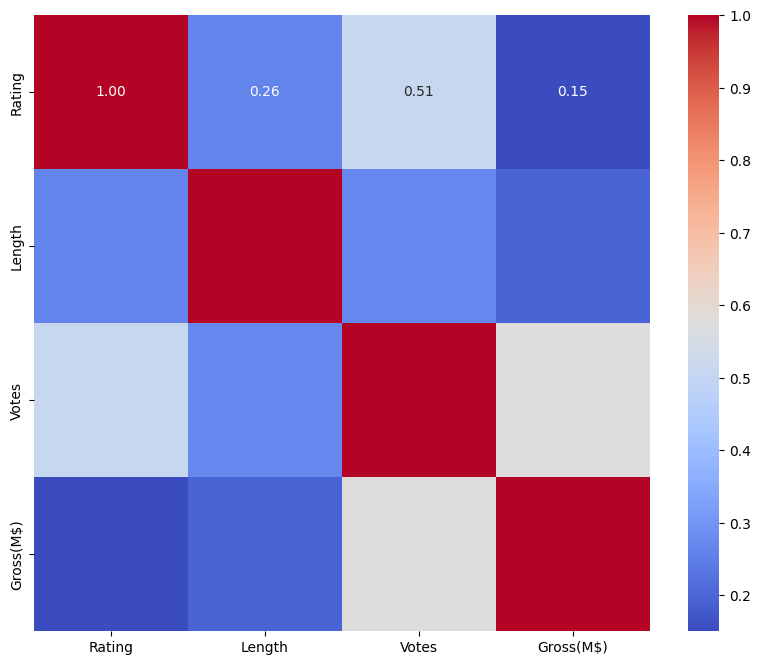

In [755]:
# Creating a smaller DataFrame with only the columns we're interested in
df_small = data_film[['Rating', 'Length', 'Votes', 'Gross(M$)']]

# Then, we calculate the correlation matrix
corr_matrix = df_small.corr()

# Finally, we create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.show()

##### Final conclusion:

- There is a moderate correlation between Rating and the Votes attribute. This indicates that the movies which receive a high number of Votes tend to have high Rating

- The Length and Gross of the movies don't affect most to the Rating of that movies. It means that the movies with a large budget doesn't mean it is a good movie and vice versa

#### 9.5) Question 5: Which director - actor pair often works together?

- Purposes: To identify frequent collaborations between directors and actors in the film industry. This can provide insights into professional relationships and recurring partnerships in filmmaking. Certain director-actor pairs often work together because they share a common vision, have a strong working relationship, or have had success together in the past. Identifying these pairs can give us a better understanding of patterns and trends in the film industry.

- Approaches: For each movie, create pairs of the director and each actor. This could involve splitting the ‘Stars’ field if it contains multiple actors, and pairing each actor with the director. Count the occurrence of each director-actor pair to see which pairs occur most frequently. Visualize the most frequent director-actor pairs using a bar plot. This can make it easier to see which pairs work together most often.

(Joel Coen, Ethan Coen)              9
(Woody Allen, Mia Farrow)            8
(John Ford, Henry Fonda)             7
(George B. Seitz, Mickey Rooney)     7
(George B. Seitz, Cecilia Parker)    6
Name: count, dtype: int64


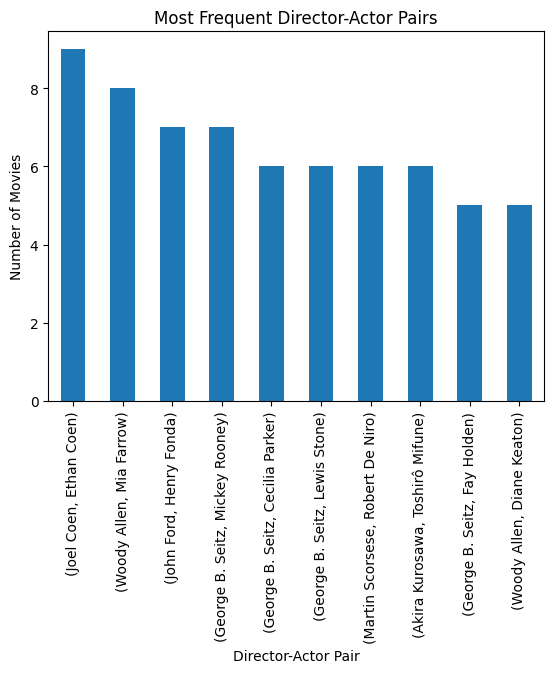

In [756]:
# Create director-actor pairs for each movie, excluding pairs where the director and actor are the same
director_actor_pairs = df_stars.apply(lambda row: (row['Director'], row['Stars_Split']) if row['Director'] != row['Stars_Split'] else None, axis=1)

# Remove None values
director_actor_pairs = director_actor_pairs.dropna()

# Count the occurrence of each director-actor pair
pair_counts = director_actor_pairs.value_counts()

# Print the most frequent director-actor pairs
print(pair_counts.head())

# If you want to visualize this, you can use the following code:
import matplotlib.pyplot as plt
pair_counts.head(10).plot(kind='bar')
plt.xlabel('Director-Actor Pair')
plt.ylabel('Number of Movies')
plt.title('Most Frequent Director-Actor Pairs')
plt.xticks(rotation=90)
plt.show()

##### Final Conclusion:

1. Joel Coen - Ethan Coen
2. Woody Allen - Mia Farrow
3. John Ford - Henry Fonda
4. George B. Seitz - Mickey Rooney
5. George B. Seitz - Cecilia Parker

These pairs have worked together on numerous projects, suggesting a strong professional relationship and a shared creative vision. Their repeated collaborations could also indicate that these pairs have found a successful formula that resonates with audiences and critics alike.

## Data modeling

- Import library for moduling

In [757]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from collections import Counter

from sklearn.model_selection import KFold


### Problem Statement

- The question that our team want to give an answer to is:  How much grosses can this new film can possibly get?
- When we want to make a film, we sure want to know how much money the film could make for us. The success or failure of a movie depends on many factor: the release date, budget, star-power, marketing,...  But with the data that our team has collected, we will answer the question above by predicting the gross with values of: Ratings, Metascore. 
- By predicting the gross, the film maker can know wheter it is possible to make the film and the prediction will help them to have a clearer vision on the plan in the production and distribution stage.


### Data preparation

In [758]:
filmdata_df = pd.read_csv("./data_film.csv")
filmdata_df.head()

,Name,Year,Genre,Length,Rating,Metascore,Votes,Gross,Director,Stars,Description
0,Bố Già,1972,"Crime, Drama",175,9.2,100.0,"1,967,180",$134.97M,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...","Don Vito Corleone, head of a mafia family, dec..."
1,Chuyện Tình Thế Chiến,1942,"Drama, Romance, War",102,8.5,100.0,"595,530",$1.02M,Michael Curtiz,"Humphrey Bogart, Ingrid Bergman, Paul Henreid,...",A cynical expatriate American cafe owner strug...
2,Sinh Viên Tốt Nghiệp,1967,"Comedy, Drama, Romance",106,8.0,83.0,"284,817",$104.95M,Mike Nichols,"Dustin Hoffman, Anne Bancroft, Katharine Ross,...",A disillusioned college graduate finds himself...
3,Công Dân Kane,1941,"Drama, Mystery",119,8.3,100.0,"458,887",$1.59M,Orson Welles,"Orson Welles, Joseph Cotten, Dorothy Comingore...",Following the death of publishing tycoon Charl...
4,12 Người Đàn Ông Giận Dữ,1957,"Crime, Drama",96,9.0,97.0,"841,356",$4.36M,Sidney Lumet,"Henry Fonda, Lee J. Cobb, Martin Balsam, John ...",The jury in a New York City murder trial is fr...


### Data Preprocessing

In [759]:
def convertDolla2Int(series):
    value = [float(x[1:-1])  for x in series ]
    return value

feature_cols = ['Rating', 'Metascore', 'Gross']

modeling_data = filmdata_df[feature_cols].copy()
modeling_data.Gross = modeling_data.Gross.fillna('$0M')
modeling_data.Gross = convertDolla2Int(modeling_data.Gross)
modeling_data.Metascore = modeling_data.Metascore.fillna(0.0)
modeling_data.Rating = modeling_data.Rating.fillna(0.0)
modeling_data

,Rating,Metascore,Gross
0,9.2,100.0,134.97
1,8.5,100.0,1.02
2,8.0,83.0,104.95
3,8.3,100.0,1.59
4,9.0,97.0,4.36
...,...,...,...
1495,7.8,47.0,59.74
1496,6.6,45.0,17.72
1497,5.4,0.0,0.00
1498,6.4,57.0,126.94


In [760]:
X, y = modeling_data.drop(['Gross'], axis= 1), modeling_data.Gross
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [761]:
train_data = X_train.join(y_train)
train_data

,Rating,Metascore,Gross
1224,6.3,56.0,25.53
786,7.7,69.0,0.00
1132,6.6,64.0,16.40
231,7.9,94.0,0.00
1179,7.7,47.0,56.12
...,...,...,...
741,7.2,77.0,8.94
183,7.8,83.0,45.70
318,7.8,91.0,0.00
468,6.8,80.0,49.11


In [762]:
test_data = X_test.join(y_test)
test_data

,Rating,Metascore,Gross
325,7.5,59.0,35.00
315,8.2,93.0,40.22
598,7.6,78.0,301.96
1134,7.7,76.0,41.91
934,7.7,73.0,277.32
...,...,...,...
71,8.1,0.0,1.09
622,8.0,0.0,0.02
379,7.2,74.0,50.28
1103,6.9,82.0,72.08


### Creating Model

In [763]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

class LogisticRegression():
    def __init__(self, lr, n_iters):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            linear_pred = np.dot(X, self.weights) + self.bias
            predictions = sigmoid(linear_pred)

            dw = (1/n_samples) * np.dot(X.T, (predictions - y))
            db = (1/n_samples) * np.sum(predictions-y)

            self.weights = self.weights - self.lr*dw
            self.bias = self.bias - self.lr*db

    def predict(self, X):
        linear_pred = np.dot(X, self.weights) + self.bias
        y_pred = sigmoid(linear_pred)
        class_pred = [0 if y<=0.5 else 1 for y in y_pred]
        return class_pred

class LinearRegression:
    def __init__(self, lr, n_iters):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0


        for _ in range(self.n_iters):
            y_pred = np.dot(X, self.weights) + self.bias
            
            dw = - ( 2 * ( X.T ).dot( y - y_pred )  ) / n_samples
            db = - 2 * np.sum( y - y_pred ) / n_samples 

            self.weights = self.weights - self.lr * dw
            self.bias = self.bias - self.lr * db
            
    def predict(self, X):
        y_pred = np.dot(X, self.weights) + self.bias
        return y_pred
    


### Chosing Metrics

In [764]:
def mse(y_test, predictions):
    return np.mean((y_test-predictions)**2)

### Trainning and Validating Model

In [765]:
X_train, y_train = train_data.drop(['Gross'], axis= 1), train_data.Gross
X_test, y_test = test_data.drop(['Gross'], axis= 1), test_data.Gross

learning_rate = 0.0001
n_iters = 100

model_1 = LinearRegression(lr= learning_rate, n_iters =n_iters)
model_2 = LogisticRegression(lr= learning_rate, n_iters =n_iters)

In [766]:
def k_fold_cross_validation(n_folds, X, y, model):
    kf = KFold(n_splits= n_folds, shuffle= True)
    fold = kf.split(X, y)
    mse_score = []
    history = {}
    count = 0
    
    for train_idx, val_idx in fold:
        X_tr = X.iloc[train_idx]
        y_tr = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        
        new_mse = mse(y_val, y_pred)
        mse_score.append(new_mse)
        print("===== Fold",count,"=====")
        print("MSE=", new_mse)
        history[count] = new_mse
        count+= 1
        

    avg_mse = np.mean(mse_score)
    return avg_mse, history

In [767]:
number_of_fold = 10

In [768]:
k_fold_linear, linear_history = k_fold_cross_validation(number_of_fold, X_train, y_train, model_1)
print("===========================")
print("Avg. MSE= ", k_fold_linear)

===== Fold 0 =====
MSE= 8030.490116837406
===== Fold 1 =====
MSE= 5328.59541835787
===== Fold 2 =====
MSE= 9025.858272241021
===== Fold 3 =====
MSE= 4459.499610992815
===== Fold 4 =====
MSE= 2943.857818356976
===== Fold 5 =====
MSE= 3888.974272181685
===== Fold 6 =====
MSE= 4529.379388595541
===== Fold 7 =====
MSE= 8225.811658638087
===== Fold 8 =====
MSE= 2259.6069038436235
===== Fold 9 =====
MSE= 4106.5395568157555
Avg. MSE=  5279.861301686078


In [769]:
k_fold_logistic, logistic_history= k_fold_cross_validation(number_of_fold, X_train, y_train, model_2)
print("===========================")
print("Avg. MSE= ", k_fold_logistic)

===== Fold 0 =====
MSE= 5542.8263633333345
===== Fold 1 =====
MSE= 7130.282031666666
===== Fold 2 =====
MSE= 4858.62992
===== Fold 3 =====
MSE= 16135.7869175
===== Fold 4 =====
MSE= 6655.7849400000005
===== Fold 5 =====
MSE= 9269.88066
===== Fold 6 =====
MSE= 4342.202125
===== Fold 7 =====
MSE= 4845.310297500001
===== Fold 8 =====
MSE= 5928.064194166666
===== Fold 9 =====
MSE= 10593.162658333336
Avg. MSE=  7530.193010750001


### Re-Train Model

In [770]:
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

### Testing Model

In [771]:
y_pred = model_1.predict(X_test)
test_mse = mse(y_test, y_pred)
print("Linear Regression Testing MSE= ", test_mse)

y_pred = model_2.predict(X_test)
test_mse = mse(y_test, y_pred)
print("Logistic Regression Testing MSE= ", test_mse)

Linear Regression Testing MSE=  5255.911655246415
Logistic Regression Testing MSE=  7624.160755666667


### Visualizing the running process

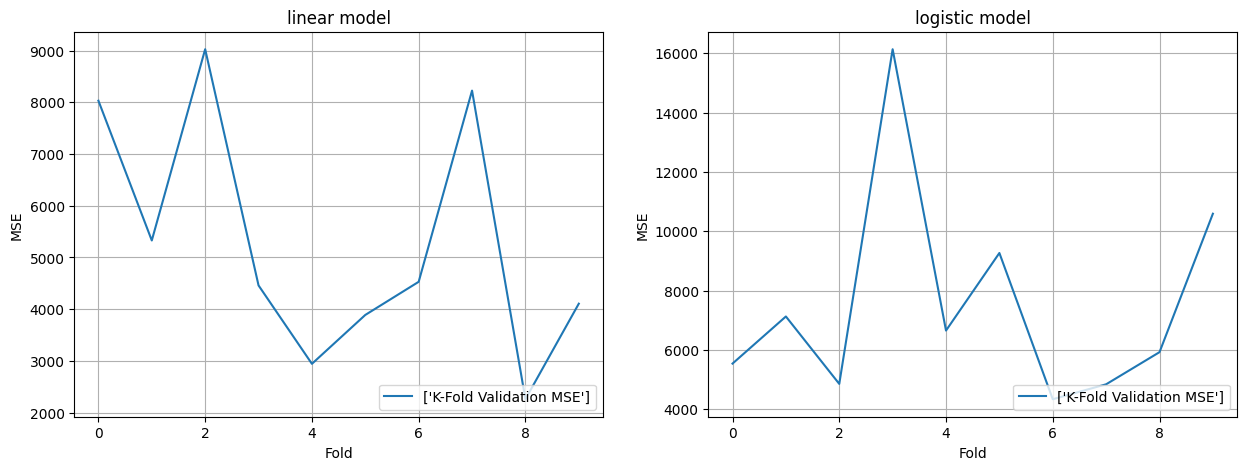

In [773]:
plt.figure(figsize=(15, 5))

history = []
for i in range(len(linear_history)):
  history.append(linear_history[i])

plt.subplot(1, 2, 1)
plt.plot(history, label=["K-Fold Validation MSE"])
plt.title("linear model")
plt.xlabel("Fold")
plt.ylabel("MSE")
plt.grid()
plt.legend(loc="lower right")

history = []
for i in range(len(logistic_history)):
  history.append(logistic_history[i])

plt.subplot(1, 2, 2)
plt.plot(history, label=["K-Fold Validation MSE"])
plt.title("logistic model")
plt.xlabel("Fold")
plt.ylabel("MSE")
plt.grid()
plt.legend(loc="lower right")

### Conclusion

## References